In [2]:
import os
import glob
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import torchvision.models as models





In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [4]:
def display_images(image_paths, title, max_images=6):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    


Train ai 총 이미지 수: 1067


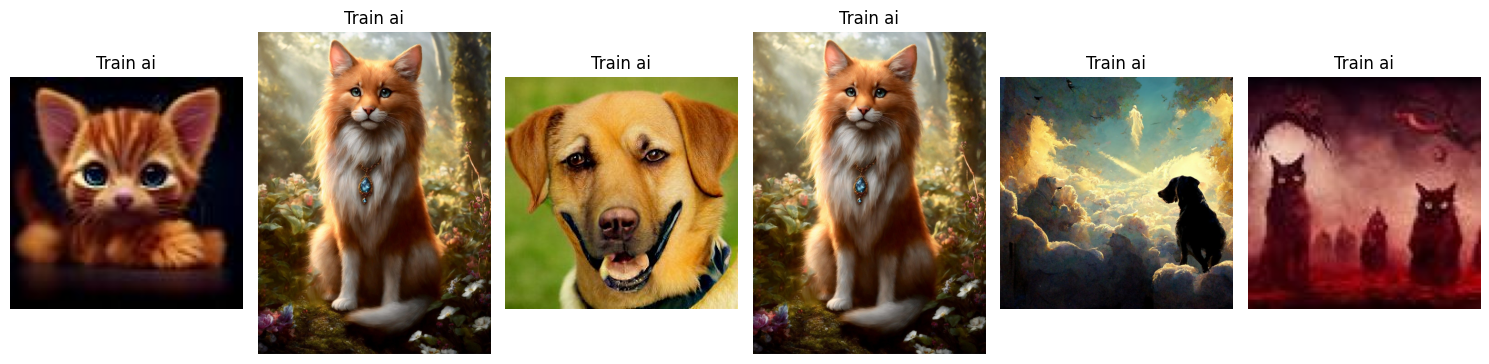

Train real 총 이미지 수: 1501


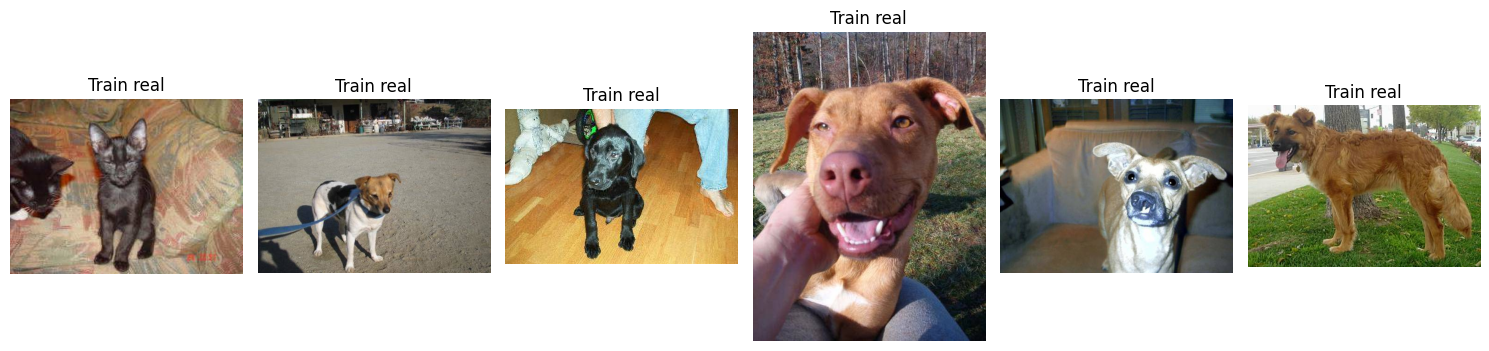

Val ai 총 이미지 수: 221


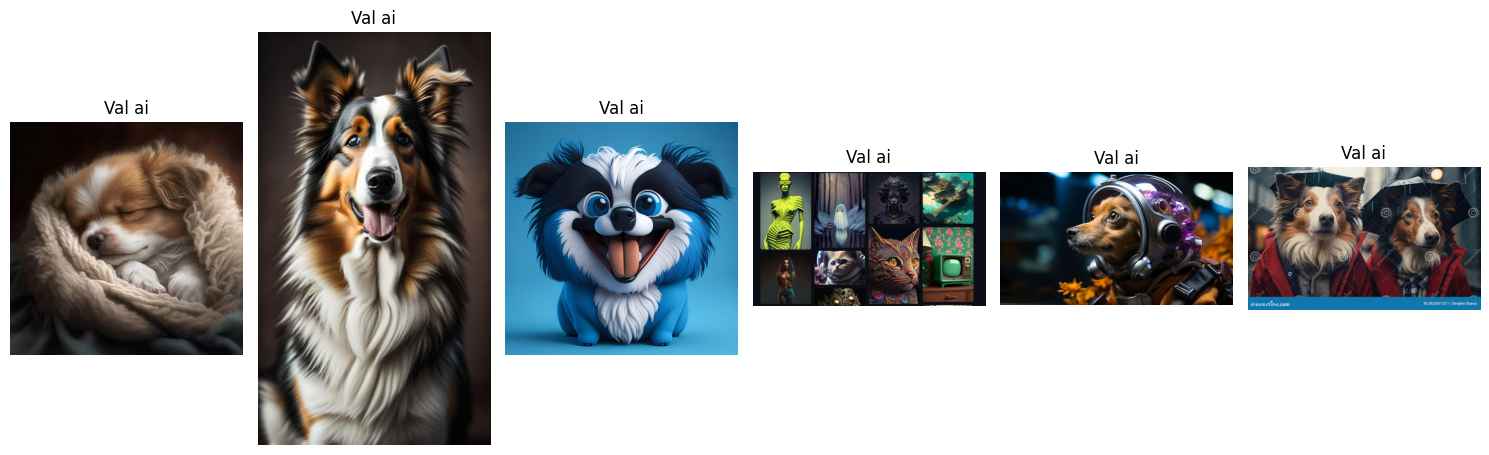

Val real 총 이미지 수: 261


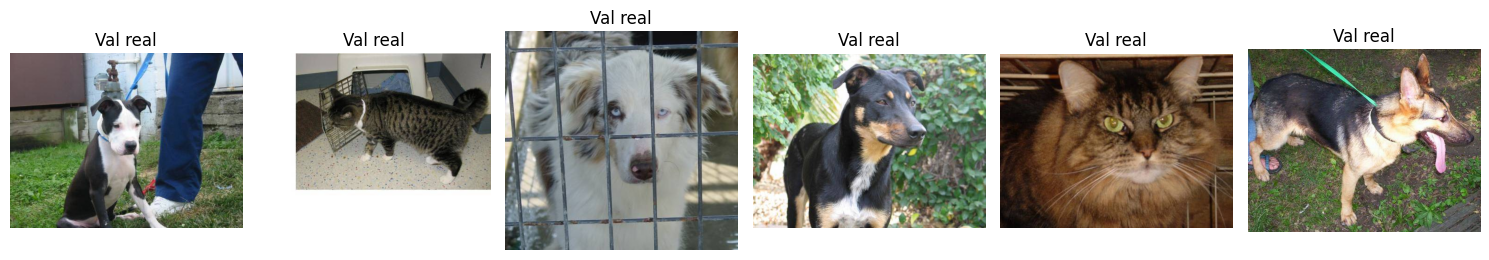

Test ai 총 이미지 수: 20


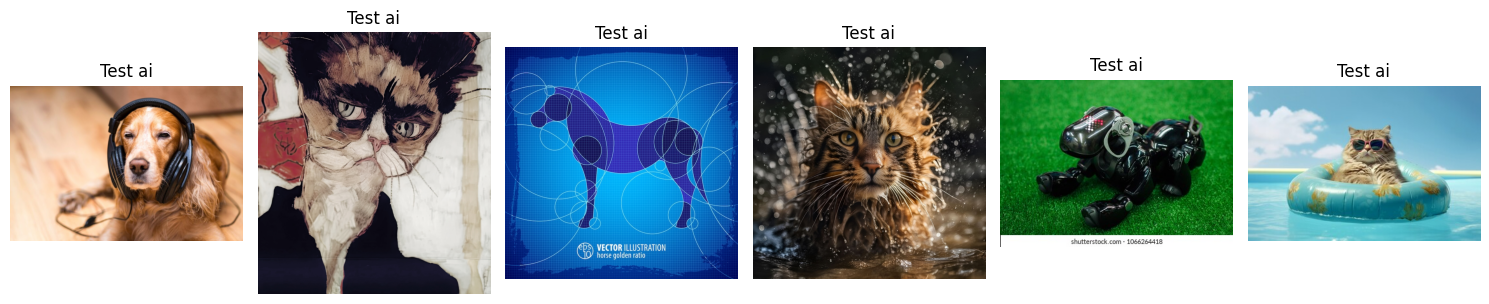

Test real 총 이미지 수: 20


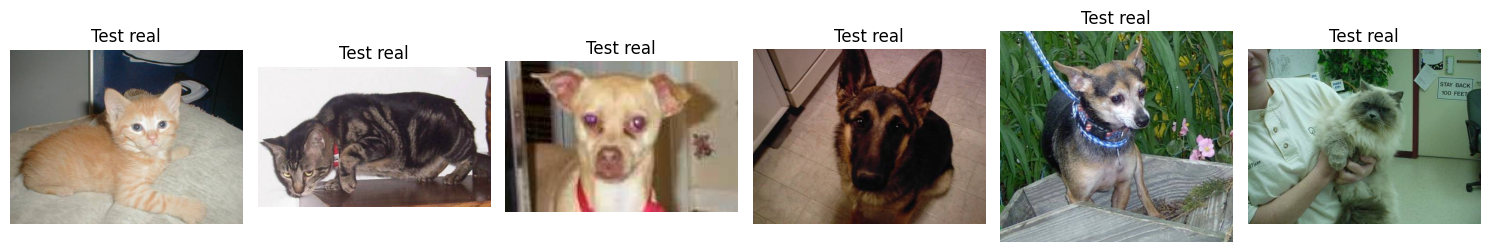

In [5]:
categories = ['Train ai', 'Train real', 'Val ai', 'Val real', 'Test ai', 'Test real']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/7/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 총 이미지 수: {len(image_paths)}')
    display_images(image_paths, [category]*len(image_paths))
    


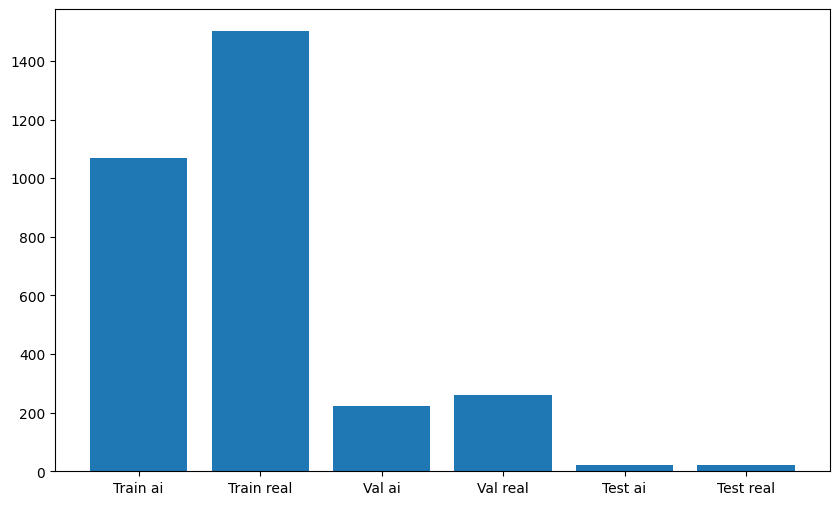

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/7/{category.lower().replace(" ", "/")}/*')) for category in categories])
plt.show()


In [7]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(
                rotate=(-20, 20), mode='symmetric'
            )
        ])
    
    def __call__(self, img):
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img
    

In [8]:
import random
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug
        
        if sample_per_class is not None:
            self.samples = self.reduce_samples(sample_per_class)
            
    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)
                
            reduced_samples = []
            for target, paths in class_samples.items():
                if len(paths) < sample_per_class:
                    reduced_samples.extend([(path, target) for path in random.sample(paths, len(paths))])
                else:
                    reduced_samples.extend([(path, target) for path in paths])
                    
        return reduced_samples
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        
        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            
            # imgaug는 numpy 배열을 반환하므로 PIL 이미지로 변환
            img = Image.fromarray(img)
            
        # ToTenser 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)
            
        return img, target

        


In [9]:
# Pytorch Transforms에서 ToTensor 및 Normalize 적용

pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [10]:
train_dataset = CustomDataset('../실습 파일/7/Train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('../실습 파일/7/Val', transform=pytorch_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)


In [11]:
# Dataloader에서 샘플을 이미지에 load해 show 함수

def imshow(img, labels, class_to_idx, size=(20, 20), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    
    for i, label in enumerate(labels[:8]):
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] / 4) + 100
        y = (i // 4) * (img.shape[0] / 2) + 10
        plt.text(x, y, f'{label.item()}: {class_name}', color='black', fontsize=14)
        
    plt.show


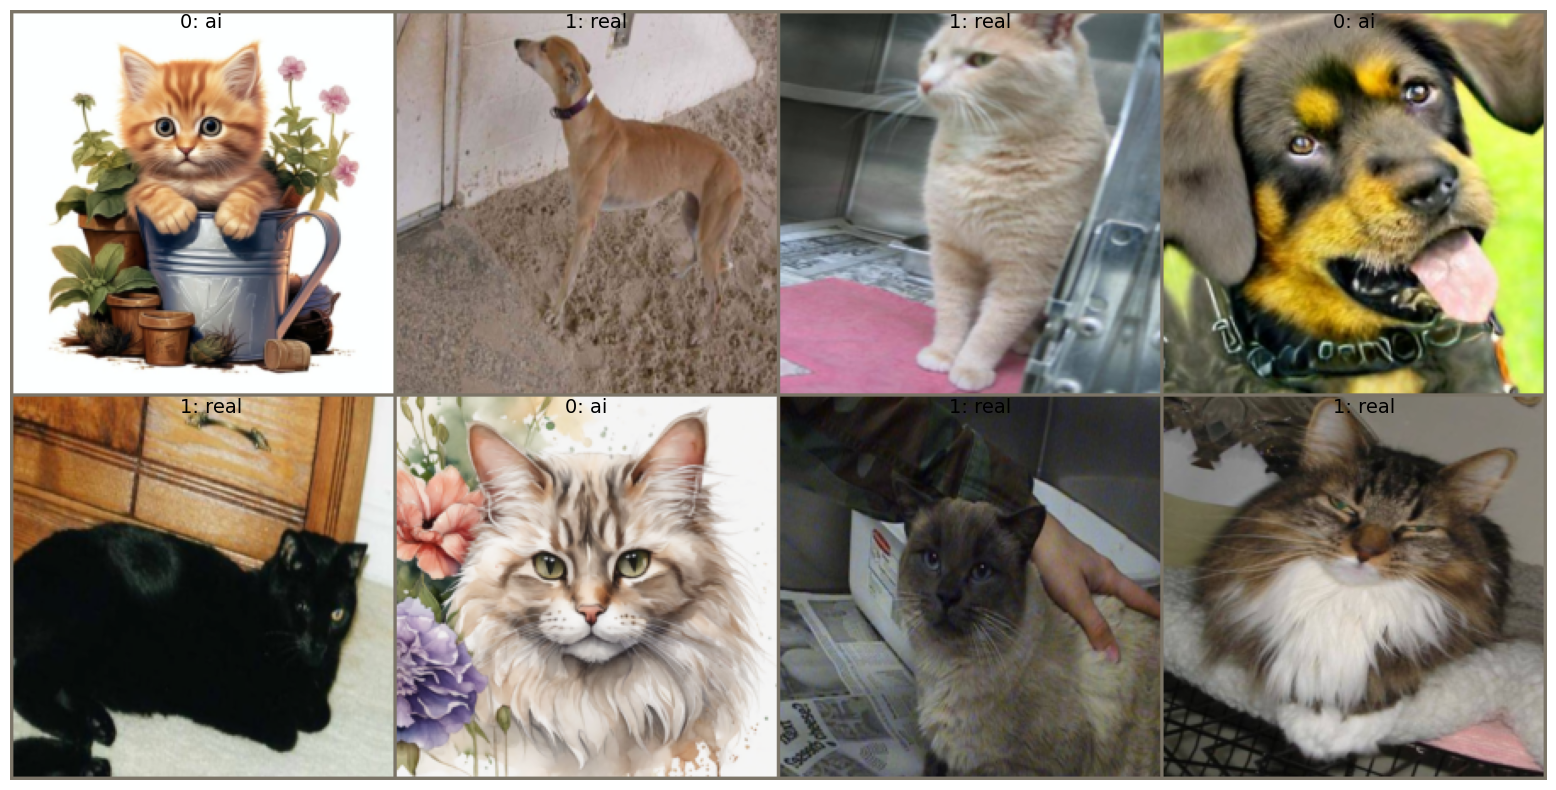

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

class_to_idx = train_loader.dataset.class_to_idx

imshow(make_grid(images[:8], nrow=4), labels[:8], class_to_idx, size=(20, 10))


In [13]:
alexnet = models.alexnet(pretrained=True)

for param in alexnet.parameters():
    param.requires_grad = False
    

alexnet.classifier[6] = nn.Linear(4096, 1)
alexnet.classifier[6].requires_grad = True

alexnet = alexnet.to(device)


c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
criterion = nn.BCEWithLogitsLoss()



In [18]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [19]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    
    # 학습/검증 손실과 검증 정확도를 저장장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1) # 레이블을 float타입으로 변환 및 차원맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        
        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')


    return train_losses, val_losses, val_accuracies

In [20]:
train_losses_alexnet, val_losses_alexnet, val_accuracies_alexnet = train_model('RAdam', alexnet, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.616143, Val Loss: 0.582930, Validation Accuracy: 72.82%
[RAdam] Epoch 2, Train Loss: 0.507972, Val Loss: 0.470349, Validation Accuracy: 82.78%
[RAdam] Epoch 3, Train Loss: 0.418195, Val Loss: 0.384242, Validation Accuracy: 87.76%
[RAdam] Epoch 4, Train Loss: 0.350434, Val Loss: 0.321375, Validation Accuracy: 92.12%
[RAdam] Epoch 5, Train Loss: 0.305780, Val Loss: 0.279647, Validation Accuracy: 93.36%
[RAdam] Epoch 6, Train Loss: 0.271570, Val Loss: 0.251145, Validation Accuracy: 93.78%
[RAdam] Epoch 7, Train Loss: 0.252119, Val Loss: 0.227784, Validation Accuracy: 95.23%
[RAdam] Epoch 8, Train Loss: 0.229099, Val Loss: 0.212502, Validation Accuracy: 95.44%
[RAdam] Epoch 9, Train Loss: 0.216629, Val Loss: 0.199463, Validation Accuracy: 95.64%
[RAdam] Epoch 10, Train Loss: 0.202246, Val Loss: 0.190524, Validation Accuracy: 95.85%
[RAdam] Epoch 11, Train Loss: 0.188131, Val Loss: 0.182643, Validation Accuracy: 95.85%
[RAdam] Epoch 12, Train Loss: 0.183045, V

In [21]:
# VGG 모델 로드 및 네트워크 구조 확인
vgg = models.vgg19(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in vgg.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
vgg.classifier[6] = nn.Linear(4096, 1)
vgg.classifier[6].requires_grad = True

vgg = vgg.to(device)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
train_losses_vgg, val_losses_vgg, val_accuracies_vgg = train_model('RAdam', vgg, train_loader, val_loader, criterion)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[RAdam] Epoch 1, Train Loss: 0.709486, Val Loss: 0.662870, Validation Accuracy: 60.17%
[RAdam] Epoch 2, Train Loss: 0.640905, Val Loss: 0.576205, Validation Accuracy: 80.91%
[RAdam] Epoch 3, Train Loss: 0.562159, Val Loss: 0.495192, Validation Accuracy: 86.31%
[RAdam] Epoch 4, Train Loss: 0.485522, Val Loss: 0.428034, Validation Accuracy: 88.59%
[RAdam] Epoch 5, Train Loss: 0.421915, Val Loss: 0.377617, Validation Accuracy: 90.46%
[RAdam] Epoch 6, Train Loss: 0.369997, Val Loss: 0.338770, Validation Accuracy: 91.70%
[RAdam] Epoch 7, Train Loss: 0.344668, Val Loss: 0.308828, Validation Accuracy: 92.32%
[RAdam] Epoch 8, Train Loss: 0.315912, Val Loss: 0.284664, Validation Accuracy: 93.15%
[RAdam] Epoch 9, Train Loss: 0.291714, Val Loss: 0.265858, Validation Accuracy: 94.19%
[RAdam] Epoch 10, Train Loss: 0.271649, Val Loss: 0.250911, Validation Accuracy: 94.19%
[RAdam] Epoch 11, Train Loss: 0.255433, Val Loss: 0.238495, Validation Accuracy: 94.19%
[RAdam] Epoch 12, Train Loss: 0.246249, V

In [23]:
# Resnet 모델 로드 및 네트워크 구조 확인
resnet = models.resnet50(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in resnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
resnet.fc = nn.Linear(2048, 1)
resnet.fc.requires_grad = True

resnet = resnet.to(device)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model('AdamW', resnet, train_loader, val_loader, criterion)

[AdamW] Epoch 1, Train Loss: 0.589409, Val Loss: 0.499871, Validation Accuracy: 86.31%
[AdamW] Epoch 2, Train Loss: 0.464311, Val Loss: 0.405396, Validation Accuracy: 94.19%
[AdamW] Epoch 3, Train Loss: 0.389292, Val Loss: 0.338207, Validation Accuracy: 93.98%
[AdamW] Epoch 4, Train Loss: 0.340622, Val Loss: 0.298367, Validation Accuracy: 94.19%
[AdamW] Epoch 5, Train Loss: 0.299370, Val Loss: 0.276242, Validation Accuracy: 95.64%
[AdamW] Epoch 6, Train Loss: 0.273226, Val Loss: 0.241345, Validation Accuracy: 95.44%
[AdamW] Epoch 7, Train Loss: 0.251353, Val Loss: 0.222307, Validation Accuracy: 94.61%
[AdamW] Epoch 8, Train Loss: 0.239982, Val Loss: 0.214900, Validation Accuracy: 95.85%
[AdamW] Epoch 9, Train Loss: 0.225206, Val Loss: 0.204177, Validation Accuracy: 96.06%
[AdamW] Epoch 10, Train Loss: 0.216427, Val Loss: 0.196134, Validation Accuracy: 95.85%
[AdamW] Epoch 11, Train Loss: 0.198989, Val Loss: 0.185517, Validation Accuracy: 95.85%
[AdamW] Epoch 12, Train Loss: 0.193816, V

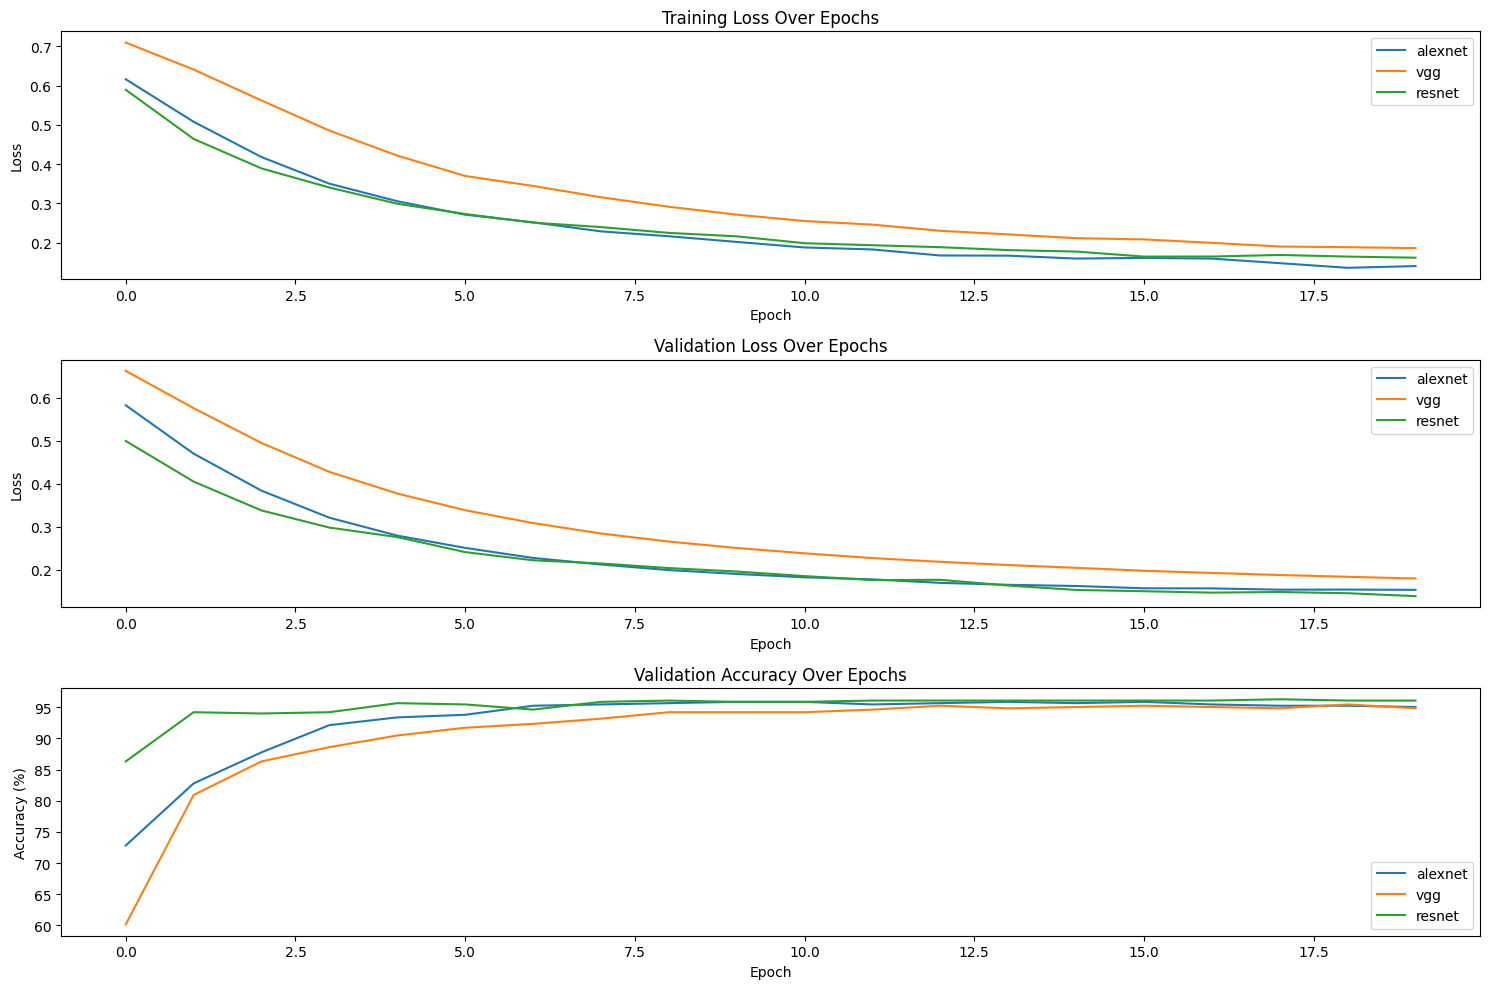

In [25]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_alexnet, label='alexnet')
plt.plot(train_losses_vgg, label='vgg')
plt.plot(train_losses_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_alexnet, label='alexnet')
plt.plot(val_losses_vgg, label='vgg')
plt.plot(val_losses_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_alexnet, label='alexnet')
plt.plot(val_accuracies_vgg, label='vgg')
plt.plot(val_accuracies_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

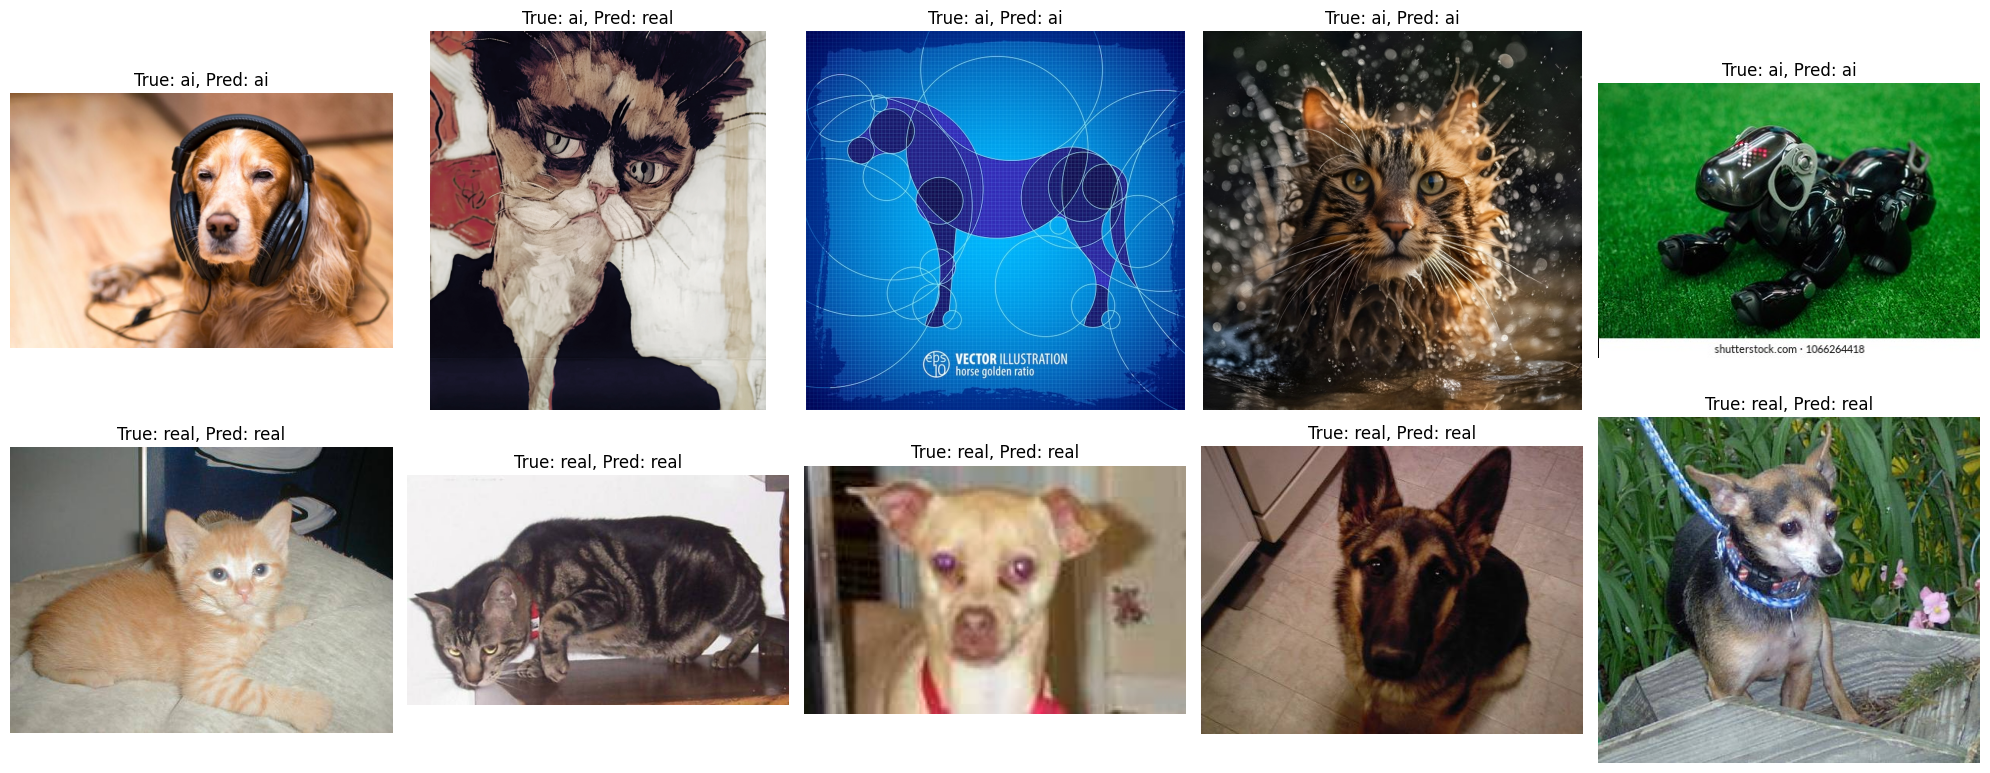

In [27]:
# 클래스별 폴더 경로
class_folders = {
    'ai': '../실습 파일/7/test/ai',
    'real': '../실습 파일/7/test/real'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        resnet.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = resnet(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'real' if probs >= 0.5 else 'ai'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'real' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1


# Evaluate models
alexnet_metrics = evaluate_model(alexnet, class_folders, pytorch_transforms)
vgg_metrics = evaluate_model(vgg, class_folders, pytorch_transforms)
resnet_metrics = evaluate_model(resnet, class_folders, pytorch_transforms)

# Print comparison
print("AlexNet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*alexnet_metrics))
print("VGGNet19 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*vgg_metrics))
print("ResNet50 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*resnet_metrics))

AlexNet Metrics: Accuracy: 0.9250, Precision: 0.9048, Recall: 0.9500, F1: 0.9268
VGGNet19 Metrics: Accuracy: 0.9750, Precision: 0.9524, Recall: 1.0000, F1: 0.9756
ResNet50 Metrics: Accuracy: 0.9500, Precision: 0.9091, Recall: 1.0000, F1: 0.9524
